<a href="https://colab.research.google.com/github/Silvia-Ding/Machine-Learning-Practice-2024/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 简述 pair trading 策略原理并举例

  * Pair Trading的基本原理是找两只高度相关的股票（或者其他资产），当它们的价格关系出现偏离时，做空价格过高的那只，同时做多价格过低的那只。等它们的价格关系回归正常时，平仓赚取差价。
  * 假设有两只股票，A股和B股：
  平时它们的价差A−B通常稳定在10元上下波动。
  某一天，A股涨到比B股多出15元，价差有点偏离正常。
  操作：
  做空A股，做多B股。
  等到几天后，A和B的价差回到10元时，平仓：
  A 股价格跌了，赚了空头收益；
  B 股价格涨了，赚了多头收益。
* 给定2022.1.1开始的银行股收益数据【ret_data】和特征值数据【feature_data】，使用特征值对股票进行分类，并选择其中一个分类构造一组pair trading 策略。要求使用R或者Python编译代码

<ipython-input-9-145ece1d6b06>:114: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
<ipython-input-9-145ece1d6b06>:114: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
<ipython-input-9-145ece1d6b06>:114: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  plt.tight_layout()
<ipython-input-9-145ece1d6b06>:114: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  plt.tight_layout()
<ipython-input-9-145ece1d6b06>:114: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
<ipython-input-9-145ece1d6b06>:114: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from curre

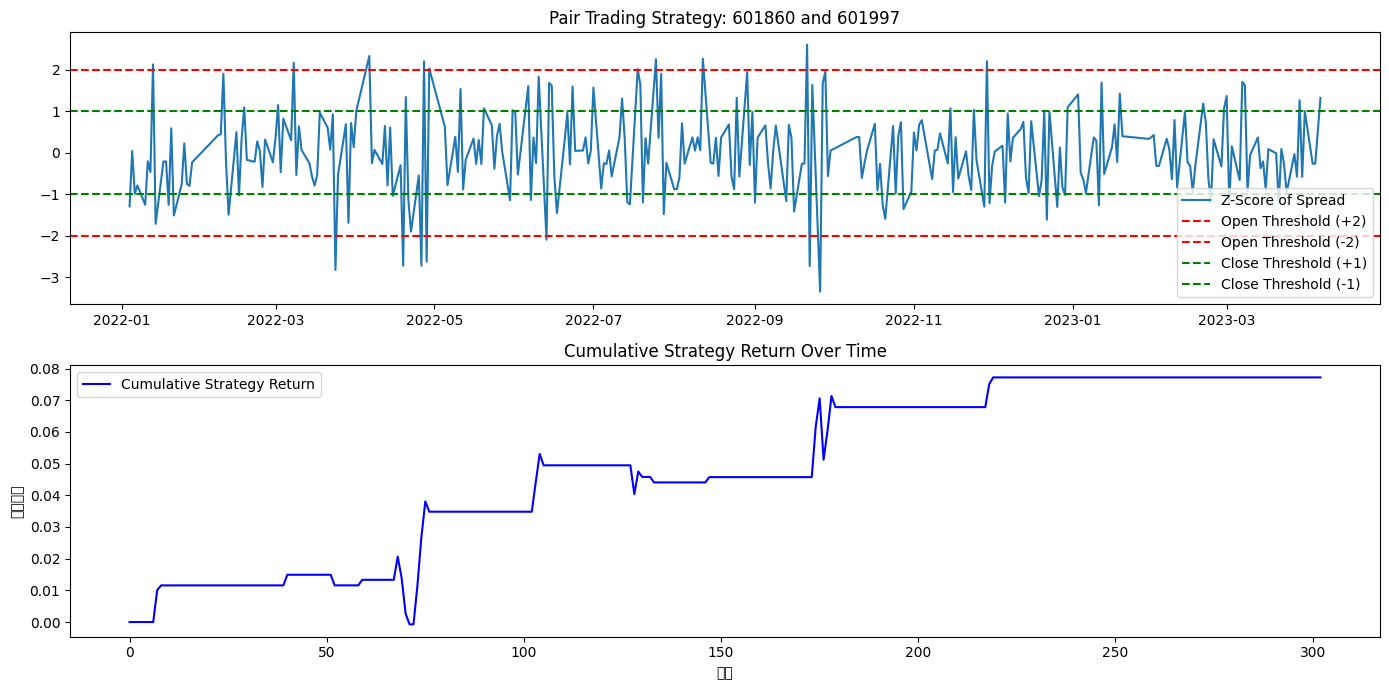

最终累计策略收益: 0.0772
选择的股票对: 601860 和 601997


In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 第一步：加载数据
feature_data_path = '/content/feature_data.csv'
ret_data_path = '/content/ret_data.csv'

feature_data = pd.read_csv(feature_data_path, index_col=0)
ret_data = pd.read_csv(ret_data_path, index_col=0, parse_dates=True)

# 第二步：预处理数据
# 将交易日期转换为日期类型
feature_data['trade_date'] = pd.to_datetime(feature_data['trade_date'], format='%Y.%m.%d')
ret_data.index = pd.to_datetime(ret_data.index)

# 合并特征数据和收益数据，按 'secu_code' 和 'trade_date' 匹配
merged_data = pd.merge(
    feature_data.reset_index(),
    ret_data.reset_index(),
    on=['secu_code', 'trade_date'],
    how='inner'
)

# 第三步：对股票进行聚类
# 基于 factor_value 进行聚类
clustering_data = merged_data[['secu_code', 'factor_value']].drop_duplicates()
kmeans = KMeans(n_clusters=3, random_state=42)  # 设置为 3 类
clustering_data['Cluster'] = kmeans.fit_predict(clustering_data[['factor_value']])
merged_data = pd.merge(merged_data, clustering_data[['secu_code', 'Cluster']], on='secu_code', how='left')

# 第四步：选择一个分类（例如 Cluster 0）用于构造配对交易策略
selected_cluster = merged_data[merged_data['Cluster'] == 0]

# 第五步：处理重复值
# 对于重复的 'trade_date' 和 'secu_code'，仅保留第一条记录
selected_cluster = selected_cluster.drop_duplicates(subset=['trade_date', 'secu_code'], keep='first').reset_index(drop=True)

# 第六步：创建收益率矩阵
# 将 'trade_date' 作为索引，'secu_code' 作为列，'ret' 作为值
returns_matrix = selected_cluster.pivot(index='trade_date', columns='secu_code', values='ret')

# 第七步：相关性分析，选择相关性高的股票对
correlation_matrix = returns_matrix.corr()  # 计算相关性矩阵
correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)  # 展开并排序
high_corr_pairs = correlation_pairs[(correlation_pairs < 1.0) & (correlation_pairs > 0.8)]  # 筛选相关性高于 0.8 的对

# 如果存在相关性高的股票对，选择其中一个
if not high_corr_pairs.empty:
    stock1, stock2 = high_corr_pairs.index[0]
else:
    raise ValueError("没有找到高相关性的股票对。")

# 第八步：构造价差
# 计算价差并标准化为 z-score
spread = returns_matrix[stock1] - returns_matrix[stock2]
spread_mean = spread.mean()
spread_std = spread.std()
spread_zscore = (spread - spread_mean) / spread_std

# 第九步：定义配对交易策略
def pair_trading_strategy(spread_zscore, threshold_open=2, threshold_close=1):
    positions_stock1 = []
    positions_stock2 = []
    for z in spread_zscore:
        if z > threshold_open:  # 做空 stock1，做多 stock2
            positions_stock1.append(-1)
            positions_stock2.append(1)
        elif z < -threshold_open:  # 做多 stock1，做空 stock2
            positions_stock1.append(1)
            positions_stock2.append(-1)
        elif abs(z) < threshold_close:  # 平仓
            positions_stock1.append(0)
            positions_stock2.append(0)
        else:  # 保持当前头寸
            if positions_stock1:
                positions_stock1.append(positions_stock1[-1])
                positions_stock2.append(positions_stock2[-1])
            else:
                positions_stock1.append(0)
                positions_stock2.append(0)
    return np.array(positions_stock1), np.array(positions_stock2)

# 第十步：生成交易信号
positions_stock1, positions_stock2 = pair_trading_strategy(spread_zscore)

# 第十一步：计算策略收益
strategy_ret = positions_stock1[:-1] * returns_matrix[stock1].iloc[1:].values + \
               positions_stock2[:-1] * returns_matrix[stock2].iloc[1:].values
cumulative_strategy_ret = np.cumsum(strategy_ret)  # 计算累计收益

# 第十二步：可视化策略表现
plt.figure(figsize=(14, 7))

# 绘制 z-score
plt.subplot(2, 1, 1)
plt.plot(spread_zscore, label='Z-Score of Spread')
plt.axhline(2, color='red', linestyle='--', label='Open Threshold (+2)')
plt.axhline(-2, color='red', linestyle='--', label='Open Threshold (-2)')
plt.axhline(1, color='green', linestyle='--', label='Close Threshold (+1)')
plt.axhline(-1, color='green', linestyle='--', label='Close Threshold (-1)')
plt.legend()
plt.title(f'Pair Trading Strategy: {stock1} and {stock2}')

# 绘制累计收益
plt.subplot(2, 1, 2)
plt.plot(cumulative_strategy_ret, label='Cumulative Strategy Return', color='blue')
plt.title('Cumulative Strategy Return Over Time')
plt.xlabel('时间')
plt.ylabel('累计收益')
plt.legend()
plt.tight_layout()
plt.show()

# 输出最终策略表现
print(f"最终累计策略收益: {cumulative_strategy_ret[-1]:.4f}")
print(f"选择的股票对: {stock1} 和 {stock2}")
